In [1]:
%pdb off
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, os.path as op
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr
import numpy as np
from pathlib import Path
from shapely.wkt import loads
from rasterio.crs import CRS
from ARIAtools.shapefile_util import open_shapefile

#Plotting
import contextily as cx
from matplotlib import pyplot as plt

#Dask
import dask
from dask.distributed import progress, Client

os.environ['USE_PYGEOS'] = '0'

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now().date())

Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(ARIA)  2023-08-31


In [2]:
def open_shapefile(fname, lyrind, ftind):
    """Open a existing shapefile and pass the coordinates back."""
    # import dependencies
    from shapely.wkt import loads

    # opening the file
    file_bbox = ogr.Open(fname)

    #If layer name provided
    if isinstance(lyrind, str):
        file_bbox = file_bbox.GetLayerByName(lyrind).GetFeature(ftind)

    #If layer index provided
    else:
        file_bbox = file_bbox.GetLayerByIndex(lyrind).GetFeature(ftind)
    geom = file_bbox.GetGeometryRef()
    file_bbox = loads(geom.ExportToWkt())

    return file_bbox

# Function to quickly get all the layers
def get_nc_groups(filename_nc : str):
    from osgeo import gdal
    #open nc file
    ds = gdal.Open(filename_nc)
    metadata = ds.GetMetadata()

    # Get Groups
    groups_df = pd.DataFrame(columns=['LAYER','PATH'])
    for layer in ds.GetSubDatasets():
        layer_df = pd.DataFrame(data={'LAYER':[layer[0].split(':')[-1].split('/')[-1]],
                                       'PATH':[layer[0]]})
        groups_df = pd.concat([groups_df, layer_df], ignore_index=True)
    #close
    ds = None

    return groups_df, metadata


def ds_get_extent(gdal_ds):
    E = gdal_ds.GetGeoTransform()[0]
    W = gdal_ds.GetGeoTransform()[0] + gdal_ds.GetGeoTransform()[1] * gdal_ds.RasterXSize
    N = gdal_ds.GetGeoTransform()[3] 
    S = gdal_ds.GetGeoTransform()[3] + gdal_ds.GetGeoTransform()[5] * gdal_ds.RasterYSize
    return [E, W, S, N]

In [3]:
# select dirs
path_data = os.getenv('dataroot')
raid_dir  = 'Tests' if 'leffe' in path_data else 'Exps'


# Download

In [6]:
import hyp3_sdk
import concurrent.futures
from tqdm import tqdm

job_name = 'track4-n3'
user_id = 'cmarshak'
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu')
jobs = hyp3_isce.find_jobs(name=job_name, user_id=user_id)

In [ ]:
save_dir = Path(products_dir)
# Download files in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm(executor.map(lambda job: job.download_files(save_dir), jobs), total=len(jobs)))

# Prepare

In [7]:
@dask.delayed
def _get_dataframe(filename):
    name = filename.name 
    df = pd.DataFrame(data={'SENSOR':[name.split('-')[0]],
                            'ORBIT' :[name.split('-')[2]],
                            'TRACK' :[name.split('-')[4]],
                            'DATE1_DATE2':[name.split('-')[6]],
                            'PATH':[str(filename)]})

    # Get Geometry TODO run this in parallel
    # Geting warning message 
    # Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
    boundingBox_layer = f'NETCDF:"{str(filename)}":productBoundingBox'
    geom = open_shapefile(boundingBox_layer, 'productBoundingBox', 1)
    df['GEOMETRY'] = [geom]

    # Get Version
    ds = gdal.Open(str(filename), gdal.GA_ReadOnly)
    df['VERSION'] = [ds.GetMetadata()['NC_GLOBAL#version']]
    ds = None
    return df


#But if I run it without decorater, I am not getting errors?
# But is slower
def _get_dataframe1(filename):
    df = pd.DataFrame(data={'SENSOR':[filename.name.split('-')[0]],
                            'ORBIT' :[filename.name.split('-')[2]],
                            'TRACK' :[filename.name.split('-')[4]],
                            'DATE1_DATE2':[filename.name.split('-')[6]],
                            'PATH':[str(filename)]})

    # Get Geometry TODO run this in parallel
    boundingBox_layer = f'NETCDF:"{str(filename)}":productBoundingBox'
    geom = open_shapefile(boundingBox_layer, 'productBoundingBox', 1)
    df['GEOMETRY'] = [geom]

    # Get Version
    ds = gdal.Open(str(filename), gdal.GA_ReadOnly)
    df['VERSION'] = [ds.GetMetadata()['NC_GLOBAL#version']]
    ds = None
    return df   

def get_gunw_dataframe(work_dir, n_jobs=1, verbose=False):
    # verbose printing
    vprint = lambda x: print(x) if verbose == True else None

    vprint(f'GUNW directory: {work_dir}')
    n_gunws = len(list(work_dir.glob('*S1*')))
    vprint(f'Number of GUNW products: {n_gunws}')

    # initalize multiprocessing
    if n_jobs>1:
        client = Client(threads_per_worker=1, 
                        n_workers=n_jobs,
                        memory_limit='1GB')
        vprint(f'Link: {client.dashboard_link}')
    else:
        client = None
    
    # Prepare jobs
    jobs = []
    for filename in work_dir.glob('*S1*'):
        #jobs.append(dask.delayed(_get_dataframe1)(filename))
        jobs.append(_get_dataframe(filename))

    # Run export jobs
    vprint(f'Run number of jobs: {len(jobs)}')
    out = dask.compute(*jobs)

    # close dask
    if client:
        client.close()

    df = pd.concat(out, ignore_index=True)
    gdf = gpd.GeoDataFrame(df, crs = "EPSG:4326", geometry=df['GEOMETRY'])

    return gdf

In [8]:
%%time
gunw_df = get_gunw_dataframe(products_dir/ 'selected', n_jobs=20, verbose=True)

GUNW directory: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/products_track4/selected
Number of GUNW products: 9208
Link: http://127.0.0.1:8787/status
Run number of jobs: 9208


Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a L

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

CPU times: user 39.6 s, sys: 13.9 s, total: 53.5 s
Wall time: 1min 2s


SENSOR ORBIT TRACK        DATE1_DATE2  \
0     S1     A   004  20210326_20200903   
1     S1     A   004  20210326_20200903   
2     S1     A   004  20210326_20200903   
3     S1     A   004  20210326_20200903   
4     S1     A   004  20210326_20200903   

                                                PATH  \
0  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
1  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
2  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
3  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
4  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   

                                            GEOMETRY VERSION  \
0  POLYGON ((-75.2536305341246 35.6513333561772, ...      1c   
1  POLYGON ((-78.040641976138 35.2794837158725, -...      1c   
2  POLYGON ((-77.3914567507339 36.5809042212366, ...      1c   
3  POLYGON ((-78.9749135134617 39.1131792916331, ...      1c   
4  POLYGON ((-75.8909641385913 38.780654066845, -...      1c   

                                            geometry  
0  POLYGON ((-75.25363 35.65133, -74.95005 34.137...  
1  POLYGON ((-78.04064 35.27948, -78.40307 36.791...  
2  POLYGON ((-77.39146 36.58090, -78.31846 36.441...  
3  POLYGON ((-78.97491 39.11318, -77.93428 39.264...  
4  POLYGON ((-75.89096 38.78065, -76.83617 38.658...

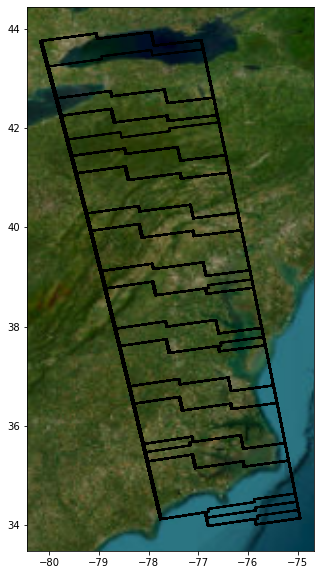

In [17]:
# Group by same date
gdf_date12 = gunw_df.groupby('DATE1_DATE2', group_keys=True).apply(lambda x: x).set_crs(4326)


# Plot
fig, ax = plt.subplots(figsize=(10,10))
gdf_date12.exterior.plot(color='black', ax=ax)
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)

gdf_date12.head()

In [18]:
# Get the bounds
gdf_date12.unary_union.bounds

(-80.1877256377741, 33.9811401179965, -74.9407482622201, 43.9344930899224)

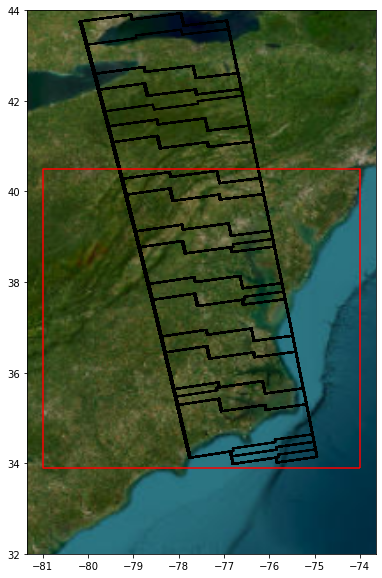

In [20]:
# Clip the dataframe
from shapely.geometry import box
polygon = box(-81, 33.9, -74, 40.5)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_date12.crs)

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_date12.exterior.plot(color='black', ax=ax)
poly_gdf.exterior.plot(color='red', ax=ax)
ax.set_ylim([32,44]) # TODO get this from the geoDataframe
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)

# Clip the dataframe
gdf_date12_clipped = gdf_date12.clip(polygon)

<AxesSubplot:>

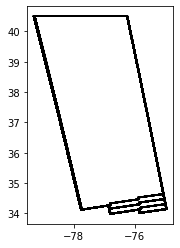

In [21]:
# Find union geometries per pair
unioned_geometries = []
for group_name, group_data in gunw_df.groupby('DATE1_DATE2', group_keys=True):
    unioned_geometry = group_data.unary_union
    unioned_geometries.append(unioned_geometry)

unioned_gdf = gpd.GeoDataFrame(
    {'DATE1_DATE2': gunw_df.groupby('DATE1_DATE2', group_keys=True).groups.keys(),
    'geometry': unioned_geometries},
    geometry='geometry')

# Clip
gdf_date12_clipped = unioned_gdf.clip(polygon)
gdf_date12_clipped.exterior.plot(color='black')

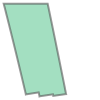

In [22]:
gdf_date12_clipped.unary_union

(array([ 16.,   0.,  58.,   4.,   1.,  47.,   0.,   0.,  26., 999.]),
 array([17.82785566, 17.9328699 , 18.03788413, 18.14289836, 18.24791259,
        18.35292682, 18.45794105, 18.56295528, 18.66796952, 18.77298375,
        18.87799798]),
 <BarContainer object of 10 artists>)

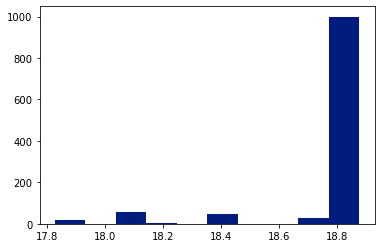

In [23]:
# Clipped areas
plt.hist(gdf_date12_clipped.area)

In [24]:
# Get all the pairs
pairs = gdf_date12_clipped.groupby('DATE1_DATE2').groups.keys()

# Get norm of all unioned pairs areas
norm = gdf_date12_clipped.area / gdf_date12_clipped.area.max()

In [25]:
# Threshold based on the percentage of the areas coveref in aoi
threshold = 0.9 # 90%
gdf_selected = gdf_date12_clipped[norm >= threshold]
gdf_rejected = gdf_date12_clipped[norm < threshold]

/u/leffe-data2/buzzanga/Miniconda3/envs/ARIA/lib/python3.9/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Number of kept pairs: 1151
Number of rejected pairs: 0


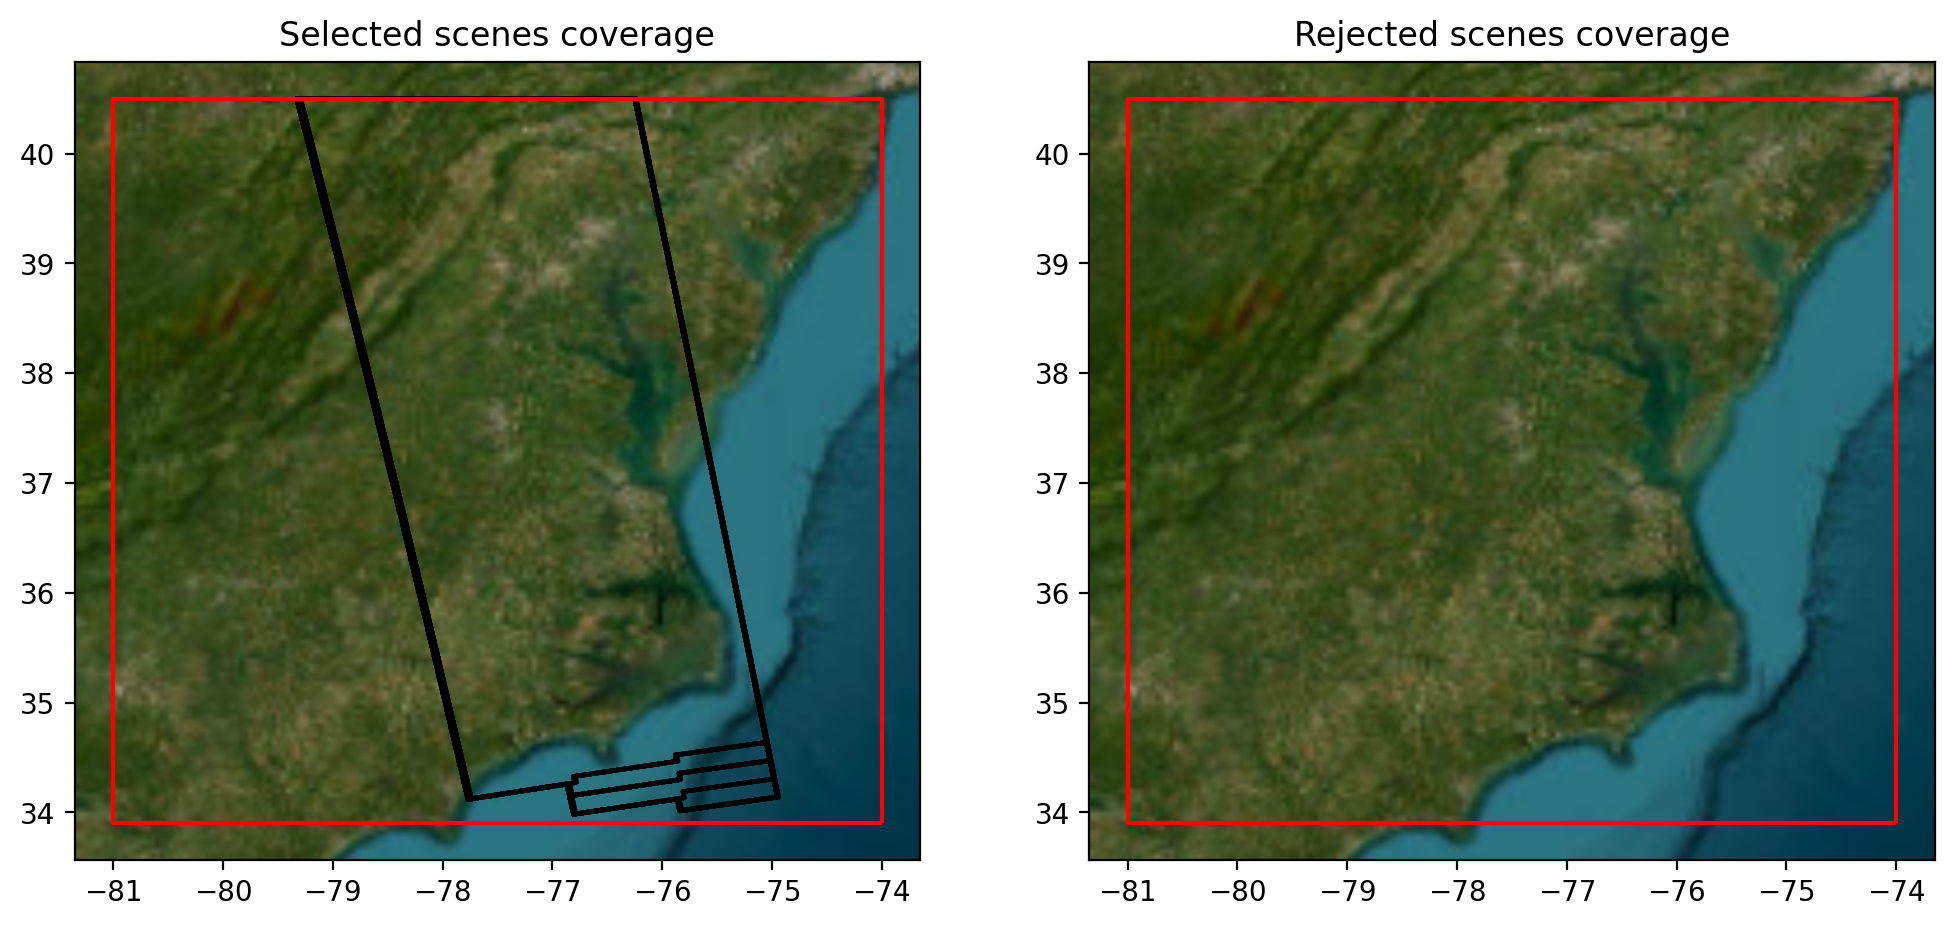

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,12), dpi=200)
gdf_selected.exterior.plot(color='black', ax=ax[0])
poly_gdf.exterior.plot(color='red', ax=ax[0])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)
ax[0].set_title('Selected scenes coverage')

gdf_rejected.exterior.plot(color='black', ax=ax[1])
poly_gdf.exterior.plot(color='red', ax=ax[1])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery, crs=gdf_date12.crs, attribution=False)
ax[1].set_title('Rejected scenes coverage')


print(f'Number of kept pairs: {gdf_selected.shape[0]}')
print(f'Number of rejected pairs: {gdf_rejected.shape[0]}')

In [28]:
gdf_rejected

Empty GeoDataFrame
Columns: [DATE1_DATE2, geometry]
Index: []

In [29]:
# Get the rejected dates
rejected_dates = []
for _, rejected in gdf_rejected['DATE1_DATE2'].items():
    rejected_dates.append(rejected.split('_')) 

dates, counts = np.unique(rejected_dates, return_counts=True)
print(f'Probably DATES with missing SLCs {dates[counts > 1]}')

Probably DATES with missing SLCs []


In [30]:
dates, counts

(array([], dtype=float64), array([], dtype=int64))

In [ ]:
selected_dir = Path(gunw_df['PATH'][0]).parent / 'selected'
rejected_dir = Path(gunw_df['PATH'][0]).parent / 'rejected'

selected_dir.mkdir(parents=True, exist_ok=True)
rejected_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Separated products to different folders

for _, selected in gdf_selected.DATE1_DATE2.items():
    for _, gunw_path in gunw_df['PATH'][gunw_df['DATE1_DATE2'] == selected].items():
        filename = Path(gunw_path).name
        Path(gunw_path).rename(selected_dir / filename)

In [33]:
# Separated products to different folders
for _, rejected in gdf_rejected.DATE1_DATE2.items():
    for _, gunw_path in gunw_df['PATH'][gunw_df['DATE1_DATE2'] == rejected].items():
        filename = Path(gunw_path).name
        Path(gunw_path).rename(rejected_dir / filename)

In [35]:
for _, rejected in gdf_rejected.DATE1_DATE2.items():
    print(rejected)

In [36]:
%%time
gunw_df = get_gunw_dataframe(products_dir / 'selected', n_jobs=20, verbose=True)
gunw_df

GUNW directory: /u/leffe-data2/buzzanga/data/VLM/Sentinel1/EastCoast/products_track4/selected
Number of GUNW products: 9208
Link: http://127.0.0.1:8787/status
Run number of jobs: 9208


Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a L

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a L

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Lat

Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Longitude/X dimension.
Warning 1: dimension #0 (wkt_count) is not a Latitude/Y dimension.
Warning 1: dimension #1 (wkt_length) is not a Lo

CPU times: user 31.4 s, sys: 9.87 s, total: 41.3 s
Wall time: 42 s


SENSOR ORBIT TRACK        DATE1_DATE2  \
0        S1     A   004  20210326_20200903   
1        S1     A   004  20210326_20200903   
2        S1     A   004  20210326_20200903   
3        S1     A   004  20210326_20200903   
4        S1     A   004  20210326_20200903   
...     ...   ...   ...                ...   
9203     S1     A   004  20161006_20150825   
9204     S1     A   004  20161006_20150825   
9205     S1     A   004  20161006_20150825   
9206     S1     A   004  20161006_20150825   
9207     S1     A   004  20161006_20150825   

                                                   PATH  \
0     /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
1     /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
2     /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
3     /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
4     /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
...                                                 ...   
9203  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
9204  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
9205  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
9206  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   
9207  /u/leffe-data2/buzzanga/data/VLM/Sentinel1/Eas...   

                                               GEOMETRY VERSION  \
0     POLYGON ((-75.2536305341246 35.6513333561772, ...      1c   
1     POLYGON ((-78.040641976138 35.2794837158725, -...      1c   
2     POLYGON ((-77.3914567507339 36.5809042212366, ...      1c   
3     POLYGON ((-78.9749135134617 39.1131792916331, ...      1c   
4     POLYGON ((-75.8909641385913 38.780654066845, -...      1c   
...                                                 ...     ...   
9203  POLYGON ((-75.9651502049697 39.1347343352372, ...      1c   
9204  POLYGON ((-79.2364682506595 40.2804183535398, ...      1c   
9205  POLYGON ((-77.3635870589272 41.3413133890036, ...      1c   
9206  POLYGON ((-79.8399947954379 42.5987114197595, ...      1c   
9207  POLYGON ((-80.1515314165434 43.7572209214936, ...      1c   

                                               geometry  
0     POLYGON ((-75.25363 35.65133, -74.95005 34.137...  
1     POLYGON ((-78.04064 35.27948, -78.40307 36.791...  
2     POLYGON ((-77.39146 36.58090, -78.31846 36.441...  
3     POLYGON ((-78.97491 39.11318, -77.93428 39.264...  
4     POLYGON ((-75.89096 38.78065, -76.83617 38.658...  
...                                                 ...  
9203  POLYGON ((-75.96515 39.13473, -75.68841 37.788...  
9204  POLYGON ((-79.23647 40.28042, -78.21058 40.426...  
9205  POLYGON ((-77.36359 41.34131, -76.44962 41.453...  
9206  POLYGON ((-79.83999 42.59871, -78.77507 42.745...  
9207  POLYGON ((-80.15153 43.75722, -79.06533 43.904...  

[9208 rows x 8 columns]

# ARIAtools

### Non-Dask
Run a regular old AT on a small stack to test and compare

In [4]:
path_wd = f'{path_data}/VLM/RAiDER_{raid_dir}/aria_export_dask'
path_wd0 = op.join(path_wd, 'nondask')
path_prods = op.join(path_wd, 'products')

cmd = f"ariaTSsetup.py -f '{path_prods}/*.nc' -l all -d {path_wd}/DEM/glo_90.dem -w {path_wd0} -tm HRRR"
# print (cmd)


In [5]:
# run another one to stop and debug and figure out the inputs for tropo dask
path_wd1 = op.join(path_wd, 'nondask_test')
cmd = f"ariaTSsetup.py -f '{path_prods}/*.nc' -l troposphereWet -d {path_wd}/DEM/glo_90.dem -w {path_wd1} -sm sequential -tm HRRR"
print (cmd)

ariaTSsetup.py -f '/Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/products/*.nc' -l troposphereWet -d /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/DEM/glo_90.dem -w /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/nondask_test -sm sequential -tm HRRR


### Dask

In [6]:
from ARIAtools.ARIAProduct import ARIA_standardproduct
from ARIAtools.extractProduct import merged_productbbox, prep_dem, export_products
from ARIAtools.mask_util import prep_mask
from ARIAtools.tsSetup import generate_stack
from ARIAtools.tsSetup_dask import exportUnwrappedPhase, exportCoherenceAmplitude, exportImagingGeometry, exportTropo

In [7]:
# products_dir = Path(f'{path_data}/VLM/Sentinel1/EastCoast/products_track4')
# work_dir = Path(f'{path_data}/VLM/Sentinel1/EastCoast/track4_dask')

products_dir = Path(path_prods)
work_dir = Path(f'{path_wd}/dask_test')

os.makedirs(work_dir, exist_ok=True)

In [8]:
%%time
bbox = '34.32575 40 -78 -75.006623'
standardproduct_info = ARIA_standardproduct(op.join(path_prods, 'S1*.nc'),
# standardproduct_info = ARIA_standardproduct(str(products_dir / 'selected/S1*.nc'),
#                                             bbox=bbox,
                                            workdir=work_dir,
                                            num_threads=10,
                                            url_version=None,
                                            nc_version='1c',
                                            verbose=True)

Multi-core version
All (8) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (2) interferograms are spatially continuous.
CPU times: user 666 ms, sys: 303 ms, total: 969 ms
Wall time: 1.64 s


In [9]:
minOverlap = 1e2
(metadata_dict, product_dict, bbox_file, prods_TOTbbox,
 prods_TOTbbox_metadatalyr, arrres, proj) = merged_productbbox(
                                                            standardproduct_info.products[0],
                                                            standardproduct_info.products[1],
                                                            os.path.join(work_dir,
                                                                        'productBoundingBox'),
                                                            standardproduct_info.bbox_file,
                                                            False,
                                                            num_threads=10,
                                                            minimumOverlap=minOverlap,
                                                            verbose=True)

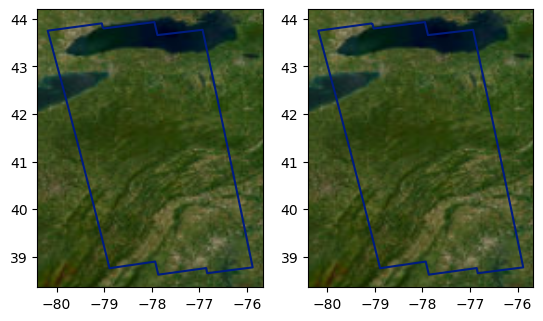

In [12]:
#Lets double check the aoi 
geo_bbox = gpd.read_file(prods_TOTbbox)
geo_bbox1 = gpd.read_file(prods_TOTbbox_metadatalyr)

fig, ax = plt.subplots(1,2)
geo_bbox.exterior.plot(ax=ax[0])
geo_bbox1.exterior.plot(ax=ax[1])

parms = dict(zoom=5, source=cx.providers.Esri.WorldImagery, crs=CRS.from_epsg(4326), zorder=0,attribution=False)
cx.add_basemap(ax[0], **parms)
cx.add_basemap(ax[1], **parms)

In [10]:
dem_filename = Path(path_wd) / 'DEM/glo_90.dem'

if  dem_filename.exists():
    dem_option = 'DEM/' + dem_filename.name
else:
    dem_option = 'download'
   
    
# Overwrite
#dem_option = 'download' # Uncomment if you want to skip Downloading

# Download/Load DEM & Lat/Lon arrays, providing bbox,
# expected DEM shape, and output dir as input.
dem, demfile, Latitude, Longitude = prep_dem(
            dem_option, bbox_file,
            prods_TOTbbox, prods_TOTbbox_metadatalyr, proj,
            arrres=arrres, workdir=str(work_dir),
            outputFormat='ISCE', num_threads=10)

dem_extent = ds_get_extent(demfile)
dem_extent

Applied cutline to produce 3 arc-sec Copernicus GLO90 DEM: /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/dask_test/DEM/glo_90.dem


[-80.18663459200009, -75.88163631400009, 38.62915121499995, 43.93248242699995]

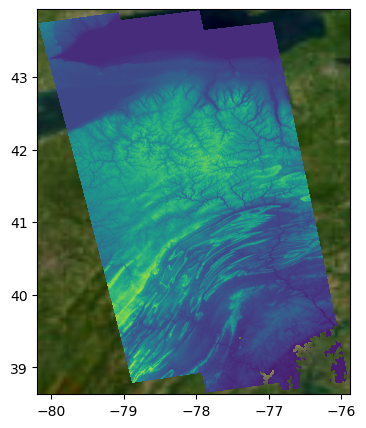

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
ax.imshow(np.ma.masked_equal(demfile.ReadAsArray(),0), extent=dem_extent, zorder=1)
cx.add_basemap(ax, zoom=5, source=cx.providers.Esri.WorldImagery, crs=CRS.from_epsg(4326), zorder=0, attribution=False)

In [18]:
%%time
# Prepare mask
amplitude_products = []
for d in product_dict:
    if 'amplitude' in d:
        for item in list(set(d['amplitude'])):
            amplitude_products.append(item)


mask_filename = Path(str(work_dir)) / 'mask/watermask.msk'

if  mask_filename.exists():
    mask_option = 'mask/' + mask_filename.name
    mask = gdal.Open(mask_filename)
else:
    mask_option = 'download'
    # Running pre_mask overwrites the current one and 
    # generates all nan file
    mask = prep_mask(amplitude_products,
                    mask_option,
                    bbox_file,
                    prods_TOTbbox, proj, 
                    amp_thresh=None,
                    arrres=arrres,
                    workdir=work_dir,
                    outputFormat='ISCE',
                    num_threads=10)

***Downloading water mask... ***
CPU times: user 5min 8s, sys: 6.37 s, total: 5min 15s
Wall time: 23min 33s


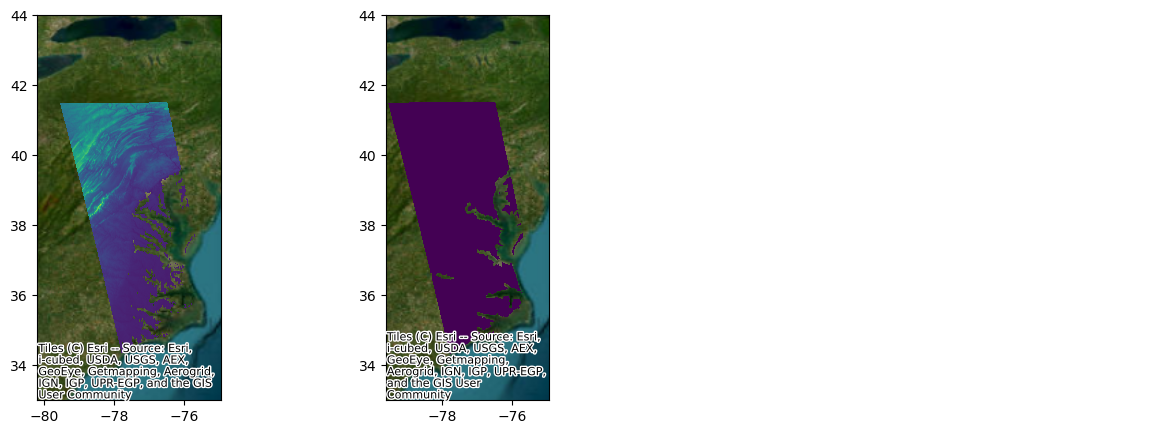

In [19]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(np.ma.masked_equal(demfile.ReadAsArray(),0),
             extent=dem_extent, zorder=1)
ax[0].set_ylim([33, 44])
cx.add_basemap(ax[0], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs=CRS.from_epsg(4326), zorder=0)

mask_extent = ds_get_extent(mask)
ax[1].imshow(np.ma.masked_equal(mask.ReadAsArray(),0),
             extent=mask_extent, zorder=1)
ax[1].set_ylim([33, 44])
cx.add_basemap(ax[1], zoom=5, source=cx.providers.Esri.WorldImagery,
               crs=CRS.from_epsg(4326), zorder=0)

# Export using Dask

## UnwrappedPhase and Connected Components

In [20]:
mask.GetDescription()

'/u/leffe-data2/govorcin/Projects/VLM_EastCoast/mask/watermask.msk'

In [67]:
%%time
exportUnwrappedPhase(product_dict, 
                      bbox_file,
                      prods_TOTbbox, arrres, work_dir,
                      mask_zero_component=False,
#                       mask=mask.GetDescription(), n_jobs=30)
                      mask=None, n_jobs=1)

Running GUNW unwrappedPhase and connectedComponents in parallel!


/Users/buzzanga/mambaforge/envs/ARIA/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59755 instead
  warnings.warn(


Link: http://127.0.0.1:59755/status
Run number of jobs: 2


/Users/buzzanga/mambaforge/envs/ARIA/lib/python3.10/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


CPU times: user 5.42 s, sys: 2.76 s, total: 8.18 s
Wall time: 1min 14s


## Coherence

In [27]:
%%time
exportCoherenceAmplitude(product_dict, 
                         bbox_file,
                         prods_TOTbbox, arrres, work_dir, 
                         #mask=mask.GetDescription(), n_threads=10, n_jobs=30)
                         mask=None, n_jobs=1)

Running GUNW coherence in parallel!


/Users/buzzanga/mambaforge/envs/ARIA/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57897 instead
  warnings.warn(


Link: http://127.0.0.1:57897/status
Run number of jobs: 2
CPU times: user 443 ms, sys: 173 ms, total: 616 ms
Wall time: 6.85 s


# Imaging Geometry

- ***'/science/grids/imagingGeometry/perpendicularBaseline'***
- '/science/grids/imagingGeometry/parallelBaseline'
- ***'/science/grids/imagingGeometry/incidenceAngle'***
- '/science/grids/imagingGeometry/lookAngle'
- ***'/science/grids/imagingGeometry/azimuthAngle'***

 Export only first scene for Incidence and Azimuth Angle

In [28]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
exportImagingGeometry(product_dict[:1], 
                      bbox_file, 
                      prods_TOTbbox, 
                      demfile, Latitude, Longitude, 
                      work_dir, layer='incidenceAngle', 
#                       mask=mask.GetDescription(), 
                      mask=None, 

                      n_threads=1, n_jobs=1)

Run number of jobs: 1 with 1 workers
CPU times: user 1.32 s, sys: 949 ms, total: 2.27 s
Wall time: 15.5 s


In [31]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
exportImagingGeometry(product_dict[:1], 
                      bbox_file, 
                      prods_TOTbbox, 
                      demfile, Latitude, Longitude, 
                      work_dir, layer='azimuthAngle', 
#                       mask=mask.GetDescription(), 
                      mask=None, 
                      n_threads=1, n_jobs=1)

Run number of jobs: 1 with 1 workers
CPU times: user 842 ms, sys: 586 ms, total: 1.43 s
Wall time: 13.4 s


In [32]:
%%time
## Take a lot of RAM memory per worker, 9GB per scene
## Dask reports leak - functions need restructuring
max_jobs = len(product_dict)
n_jobs   = 20

# Workaround solution
for n in range(0, max_jobs, n_jobs):
    if n + n_jobs > len(product_dict):
        print('Loop:', [n, max_jobs])
        product_subset = product_dict[n:max_jobs]
    else:
        print('Loop:', [n, n + n_jobs])
        product_subset = product_dict[n:n+n_jobs]

    exportImagingGeometry(product_subset,
                          bbox_file,
                          prods_TOTbbox,
                          demfile, Latitude, Longitude,
                          work_dir, layer='bPerpendicular',
#                           mask=mask.GetDescription(),
                          mask=None,
                          n_threads=5, n_jobs=n_jobs)

Loop: [0, 2]
Running GUNW bPerpendicular in parallel!


/Users/buzzanga/mambaforge/envs/ARIA/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57939 instead
  warnings.warn(


Link: http://127.0.0.1:57939/status
Run number of jobs: 2 with 20 workers
CPU times: user 5.6 s, sys: 3.12 s, total: 8.72 s
Wall time: 24.4 s


# Corrections Layers
- ***'/science/grids/corrections/external/troposphere/HRRR/reference'***
- '/science/grids/corrections/external/troposphere/HRRR/secondary'

- ***'/science/grids/corrections/external/tides/solidEarth/reference'***
- '/science/grids/corrections/external/tides/solidEarth/secondary'

In [24]:
# %%time
# %pdb off
# exportTropoSET(product_dict, bbox_file, prods_TOTbbox,
#                       demfile, Latitude, Longitude, 
#                       work_dir, layer='troposphereWet', 
#                       mask=None, 
#                       wmodel='HRRR', 
#                       n_threads=2, n_jobs=2, debug=False)

In [13]:
%%time
%pdb on
exportTropo(product_dict, bbox_file, prods_TOTbbox,
                      demfile, Latitude, Longitude, 
                      work_dir, layer='troposphereWet', 
                      mask=None, 
                      wmodel='HRRR', 
                      n_threads=2, n_jobs=2, debug=False)

Automatic pdb calling has been turned ON
Running GUNW troposphereWet in parallel!
Link: http://127.0.0.1:8787/status
Run number of reference jobs: 2 with 2 workers
Run number of secondary jobs: 2 with 2 workers
Finalizing reference: /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/dask_test/troposphereWet/20230807_20230714/HRRR/dates/20230807
Finalizing secondary: /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/dask_test/troposphereWet/20230807_20230714/HRRR/dates/20230714
Finalizing reference: /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/dask_test/troposphereWet/20230714_20230608/HRRR/dates/20230714
Finalizing secondary: /Users/buzzanga/data/VLM/RAiDER_Exps/aria_export_dask/dask_test/troposphereWet/20230714_20230608/HRRR/dates/20230608
CPU times: user 2.64 s, sys: 2.12 s, total: 4.77 s
Wall time: 37.1 s


## Generate Stacks

In [3]:
from ARIAtools.ARIA_global_variables import ARIA_STACK_OUTFILES, ARIA_STACK_DEFAULTS

In [ ]:
ref_dlist = generate_stack(standardproduct_info, 'unwrappedPhase',
                               'unwrapStack', workdir=work_dir)
stack_dict = {
    'workdir': work_dir,
    'ref_dlist': ref_dlist
}

In [7]:
# prepare additional stacks for other layers
layers = ARIA_STACK_DEFAULTS
layers.remove('unwrappedPhase')
remove_lyrs = []
for i in layers:
    lyr_dir = os.path.join(inps.workdir, i)
    if not os.path.exists(lyr_dir):
        if i in layers:
            remove_lyrs.append(i)
layers = [i for i in layers if i not in remove_lyrs]

for layer in layers:
        print('')
        if layer in ARIA_STACK_OUTFILES.keys():
            generate_stack(standardproduct_info,
                            layer,
                            ARIA_STACK_OUTFILES[layer],
                            **stack_dict)

NameError: name 'standardproduct_info' is not defined

## Compare against nonDask results

In [11]:
import rioxarray as xrr

In [14]:
path_non  = Path(f'{path_wd}/nondask_test_complete')
path_dask = Path(f'{path_wd}/dask_test')
# ifg       = '20230807_20230714'
# ifg       = 'dates/20230807' # this one looks good
# ifg       = 'dates/20230714' # if i use the first ifg, this is incorrect
ifg       = 'dates/20230608' # if i use the first ifg this is fine

In [ ]:
# ifgs
layers0 = 'unwrappedPhase coherence connectedComponents amplitude'.split()
layers1 = 'bPerpendicular bParallel lookAngle azimuthAngle incidenceAngle'.split()

# choose layer here
layer   = layers0[0]

path_unw_d = op.join(path_dask, layer, ifg)
da_d   = xrr.open_rasterio(path_unw_d, band_as_variable=True)['band_1'].rename(layer)

path_unw_n = op.join(path_non, layer, ifg)
da_n   = xrr.open_rasterio(path_unw_n, band_as_variable=True)['band_1'].rename(layer)

da_resid = da_d.copy()
da_resid.data = da_n.data - da_d.data

fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

da_n.plot(ax=axes[0])
da_d.plot(ax=axes[1])
da_resid.plot(ax=axes[2], cmap='cmc.broc')
axes[0].set_title('NonDask')
axes[1].set_title('Dask')
axes[2].set_title('Residual (NonDask-Dask)')

for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

print (f'Residual Mean: {da_resid.mean():.2f} +/- {da_resid.std():.2f}')
print (f'Residual Min|Max: {da_resid.min():.2f} | {da_resid.max():.2f}')

In [15]:
# tropo 
wm     = 'HRRR'

layers = 'troposphereWet troposphereHydrostatic troposphereTotal'.split()
layer  = layers[0] # choose layer

path_d = op.join(path_dask, layer, '20230714_20230608', wm, ifg)
da_d   = xrr.open_rasterio(path_d, band_as_variable=True)['band_1'].rename(f'{wm} {layer}')

path_n = op.join(path_non, layer, wm, ifg)
da_n   = xrr.open_rasterio(path_n, band_as_variable=True)['band_1'].rename(f'{wm} {layer}')


da_resid = da_d.copy()
da_resid.data = da_n.data - da_d.data

fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

da_n.plot(ax=axes[0])
da_d.plot(ax=axes[1])
da_resid.plot(ax=axes[2], cmap='cmc.broc')
axes[0].set_title('NonDask')
axes[1].set_title('Dask')
axes[2].set_title('Residual (NonDask-Dask)')


for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

print (f'Residual Mean: {da_resid.mean():.2f} +/- {da_resid.std():.2f}')
print (f'Residual Min|Max: {da_resid.min():.2f} | {da_resid.max():.2f}')
plt.close()

Residual Mean: 0.00 +/- 0.00
Residual Min|Max: 0.00 | 0.00
